### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30   
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [536]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        def __calc_class_error(y):
            counts = np.unique(y, return_counts=True)[1]
            probs = counts/np.sum(counts)
            if probs.shape == (0,):
                return 1
            else:
                return 1 - np.max(probs)
        
        def __calc_gini(y):
            counts = np.unique(y, return_counts=True)[1]
            probs = counts/np.sum(counts)
            return 1 - np.sum(np.square(probs))
        
        def __calc_entropy(y):
            counts = np.unique(y, return_counts=True)[1]
            probs = counts/np.sum(counts)
            return -(probs @ np.log(probs))
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.__l_sum = 0
        self.__r_sum = 0
        self.__l_squares = 0
        self.__r_squares = 0
        self.__y_criterion = 0
        # Для последнего задания
        self.feature_importances_ = None
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.criterion = criterion
        self.is_gini = criterion == "gini"
        if criterion == "gini":
            self.calc_criterion = __calc_gini
        elif self.criterion == "class_error":
            self.calc_criterion = __calc_class_error
        elif self.criterion == "entropy":
            self.calc_criterion = __calc_entropy
        else:
            raise NameError("No such criterion")

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __calc_Q(self, y, i, fast=False):
        """
        Если параметр fast=True, вычисляется с ускорением
        посредством использования атрибутов __old_criterion_l(r)
        и заранее известного impurity для y
        Иначе - вычисляется наивно
        """
        if self.is_gini and fast:
            self.__l_sum += y[i - 1]
            self.__r_sum -= y[i - 1]
            self.__l_squares += y[i - 1]**2
            self.__r_squares -= y[i - 1]**2
            h_l = (self.__l_squares/i - (self.__l_sum/i)**2)
            h_r = (self.__r_squares/(y.shape[0] - i) - (self.__r_sum/(y.shape[0] - i))**2)
            # print(y[i - 1])
            # print(self.__l_sum, self.__r_sum)
            # print(self.__l_squares, self.__r_squares)
            # print(h_l, h_r)
            h = self.__y_criterion - (h_l*i + h_r*(y.shape[0] - i))/y.shape[0]
            return h
        else:
            y_l, y_r = y[0:i], y[i:y.shape[0]]
            Q = self.__y_criterion - self.calc_criterion(y_l)*y_l.shape[0]/y.shape[0] - self.calc_criterion(y_r)*y_r.shape[0]/y.shape[0]
            return Q
    
    def __prepare_fast_count(self, y, sum_y, sum_square_y):
        self.__l_sum = 0
        self.__r_sum = sum_y
        self.__l_squares = 0
        self.__r_squares = sum_square_y
        
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        opt_feature = 0
        opt_split = x[0, 0]
        opt_Q = self.__calc_Q(y, 0)
        self.__y_criterion = self.calc_criterion(y)
        sum_y = np.sum(y)
        sum_square_y = np.sum(np.square(y))
        for feature_index in range(x.shape[1]):
            order = np.argsort(x[:, feature_index])
            reordered_y = y[order]
            reordered_x = x[order, :]
            
            y_prev_index = 0
            flag = False
            if self.is_gini:
                self.__prepare_fast_count(y, sum_y, sum_square_y)
            for i in range(1, x.shape[0] - 1):
                if reordered_y[i] == reordered_y[y_prev_index]:
                    flag = True
                    continue
                if self.is_gini and flag:
                    self.__l_sum += np.sum(reordered_y[y_prev_index + 1:i])
                    self.__r_sum -= np.sum(reordered_y[y_prev_index + 1:i])
                    self.__l_squares += np.sum(np.square(reordered_y[y_prev_index + 1:i]))
                    self.__r_squares -= np.sum(np.square(reordered_y[y_prev_index + 1:i]))

                y_prev_index = i
                running_Q = self.__calc_Q(reordered_y, i, True)
                if running_Q > opt_Q:
                    opt_Q = running_Q
                    opt_feature = feature_index
                    opt_order = order
                    opt_split = (reordered_x[i - 1, opt_feature] + reordered_x[i, opt_feature])/2
        return opt_feature, opt_split, opt_Q
    
    def __leaf_class_predict(self, y):
        counts =  np.unique(y, return_counts=True)
        return counts[0][np.argmax(counts[1])]
            
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth >= self.max_depth:
            pred = self.__leaf_class_predict(y)
            prob = np.sum(y == pred)/y.shape[0]
            new_node = (self.LEAF_TYPE, pred, prob)
            self.tree[node_id] = new_node
        else:
            opt_feature, opt_split, opt_Q = self.__find_threshold(x, y)
            reordered_opt_feature = x[:, opt_feature]
            l_index = reordered_opt_feature < opt_split
            r_index = reordered_opt_feature >= opt_split
            x_l = x[l_index]
            x_r = x[r_index]
            y_l = y[l_index]
            y_r = y[r_index]
            if y_l.shape[0] <= self.min_samples_split or y_r.shape[0] <= self.min_samples_split:
                pred = self.__leaf_class_predict(y)
                prob = np.sum(y == pred)/y.shape[0]
                new_node = (self.LEAF_TYPE, pred, prob)
                self.tree[node_id] = new_node
            else:
                new_node = (self.NON_LEAF_TYPE, opt_feature, opt_split)
                self.feature_importances_[opt_feature] += opt_Q
                self.tree[node_id] = new_node
                self.__fit_node(x_l, y_l, 2*node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2*node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = dict.fromkeys(range(x.shape[1]), 0)
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] < threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        importances = np.zeros(len(self.feature_importances_))
        for k, i in self.feature_importances_.items():
            importances[k] = i
        return importances/np.sum(importances)

In [520]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [521]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [522]:
my_clf.fit(X_train, y_train)

In [523]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [524]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

1.0

In [525]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

1.0

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [441]:
%time clf.fit(X_train, y_train)

CPU times: user 216 µs, sys: 3.76 ms, total: 3.98 ms
Wall time: 2.7 ms


DecisionTreeClassifier()

### Оптимзационный алгоритм реализован, но ускорение не дотягивает :(

In [442]:
%time my_clf.fit(X_train, y_train)

CPU times: user 63.7 ms, sys: 0 ns, total: 63.7 ms
Wall time: 62.6 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [92]:
data = pd.read_csv("./Speed Dating Data.csv", sep=",", encoding="latin1")

In [93]:
data.shape

(8378, 195)

In [94]:
data.drop(["id"], axis=1)
data.drop(["idg"], axis=1)

,iid,id,gender,condtn,wave,round,position,positin1,order,partner,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,10,7,NaN,4,1,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,10,7,NaN,3,2,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,10,7,NaN,10,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,10,7,NaN,5,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,10,7,NaN,7,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,2,21,22,14,10.0,5,18,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,2,21,22,13,10.0,4,19,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,2,21,22,19,10.0,10,20,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,2,21,22,3,10.0,16,21,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [95]:
data.drop_duplicates(subset=["iid"]).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

In [96]:
data = data.drop(['round', "position", "order",
                  "partner", 'age_o', 'race_o', 'pf_o_att', 
                  'pf_o_sin', 'pf_o_int',
                  'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
                  'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
                  'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
                 axis=1)

<AxesSubplot:>

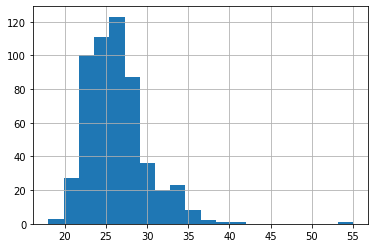

In [97]:
data.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [98]:
data = data.dropna(subset=['age'])

In [99]:
data.loc[:, 'field_cd'] = data.loc[:, 'field_cd'].fillna(19)

In [100]:
data = data.drop(['field'], axis=1)

In [101]:
data.field_cd

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
8373    18.0
8374    18.0
8375    18.0
8376    18.0
8377    18.0
Name: field_cd, Length: 8283, dtype: float64

In [102]:
def mean_target_encoding(df, target, column):
    mean_enc = df.groupby(column)[target].mean()
    df[column+'_m_enc'] = df[column].map(mean_enc)
    return df
data = mean_target_encoding(data, "match", "field_cd")

In [103]:
data.field_cd_m_enc

0       0.204511
1       0.204511
2       0.204511
3       0.204511
4       0.204511
          ...   
8373    0.153846
8374    0.153846
8375    0.153846
8376    0.153846
8377    0.153846
Name: field_cd_m_enc, Length: 8283, dtype: float64

In [104]:
data = data.drop(['field_cd'], axis=1)

In [105]:
data = data.drop(['undergra'], axis=1)

In [106]:
data.loc[:, 'mn_sat'] = data.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

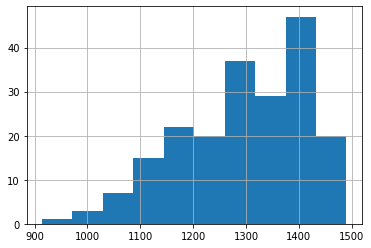

In [107]:
data.drop_duplicates('iid').mn_sat.hist()

Заполним пропуски индикатором - нулем

In [108]:
data["mn_sat"] = data["mn_sat"].fillna(0)

<AxesSubplot:>

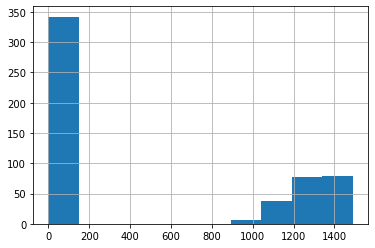

In [109]:
data.drop_duplicates('iid').mn_sat.hist()

In [110]:
data.loc[:, 'tuition'] = data.loc[:, 'tuition'].str.replace(',', '').astype(float)

<AxesSubplot:>

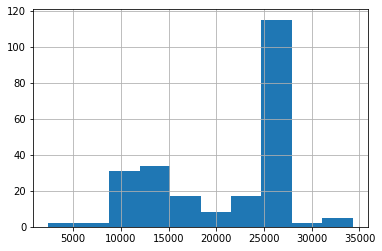

In [111]:
data.drop_duplicates('iid').tuition.hist()

In [112]:
data["tuition"] = data["tuition"].fillna(-10000)

In [113]:
data = mean_target_encoding(data, "match", "race")

In [114]:
data = data.drop(['race'], axis=1)

In [115]:
data.drop_duplicates('iid').imprace.isnull().sum()

1

In [116]:
data.drop_duplicates('iid').imprelig.isnull().sum()


1

In [117]:
data = data.dropna(subset=['imprelig', 'imprace'])

In [118]:
data = data.drop(['from', 'zipcode'], axis=1)

In [119]:
data.loc[:, 'income'] = data.loc[:, 'income'].str.replace(',', '').astype(float)

In [120]:
data = data.drop(['income'], axis=1)

In [121]:
data = mean_target_encoding(data, "match", "goal")
data = mean_target_encoding(data, "match", "date")
data = mean_target_encoding(data, "match", "go_out")

In [122]:
data = data.drop(['goal'], axis=1)
data = data.drop(['date'], axis=1)
data = data.drop(['go_out'], axis=1)

In [123]:
for i, group in data.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [124]:
data = mean_target_encoding(data, "match", "career_c")
data = data.drop(['career_c', "career"], axis=1)

In [125]:
data = data.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [126]:
data = data.drop(['expnum'], axis=1)

In [127]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = data.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100

In [128]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = data.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100
data = data.drop(['temp_totalsum'], axis=1)


In [129]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    data = data.drop(feat, axis=1)

In [132]:
data = data.drop("positin1", axis=1)

In [137]:
data = data.dropna(subset=['career_c_m_enc'])

In [139]:
data = data.drop(['id'], axis=1)

In [153]:
for i in [7]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    data = data.drop(feat, axis=1)

KeyError: "['attr7_1' 'sinc7_1' 'intel7_1' 'fun7_1' 'amb7_1'] not found in axis"

In [174]:
features = list(data.columns)
bad_features = list(filter(lambda x: x[-1].isnumeric() and int(x[-1]) > 1, features))

In [170]:
data = data.drop(bad_features, axis=1)

In [182]:
bad_features = list(filter(lambda x: x[-2:] == "_s", features))
bad_features

['attr1_s',
 'sinc1_s',
 'intel1_s',
 'fun1_s',
 'amb1_s',
 'shar1_s',
 'attr3_s',
 'sinc3_s',
 'intel3_s',
 'fun3_s',
 'amb3_s']

In [183]:
data = data.drop(bad_features, axis=1)

In [195]:
data = data.drop(["you_call", "them_cal"], axis=1)

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8208 entries, 30 to 8377
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iid             8208 non-null   int64  
 1   gender          8208 non-null   int64  
 2   idg             8208 non-null   int64  
 3   condtn          8208 non-null   int64  
 4   pid             8208 non-null   float64
 5   match           8208 non-null   int64  
 6   int_corr        8208 non-null   float64
 7   samerace        8208 non-null   int64  
 8   age             8208 non-null   float64
 9   mn_sat          8208 non-null   float64
 10  tuition         8208 non-null   float64
 11  imprace         8208 non-null   float64
 12  imprelig        8208 non-null   float64
 13  exphappy        8208 non-null   float64
 14  attr1_1         8208 non-null   float64
 15  sinc1_1         8208 non-null   float64
 16  intel1_1        8208 non-null   float64
 17  fun1_1          8208 non-null   

In [ ]:
data = data.drop(['wave'], axis=1)

In [208]:
data = data.fillna(data.mean())

In [213]:
data_male = data.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
data_female = data.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
data_female.columns = data_female.columns + '_f'

In [227]:
data_female.index = data_female.iid_f
data_female

,iid_f,idg_f,condtn_f,pid_f,age_f,mn_sat_f,tuition_f,imprace_f,imprelig_f,exphappy_f,...,prob_f,met_f,match_es_f,length_f,field_cd_m_enc_f,race_m_enc_f,goal_m_enc_f,date_m_enc_f,go_out_m_enc_f,career_c_m_enc_f
iid_f,,,,,,,,,,,,,,,,,,,,,
4,4,7,1,11.0,23.0,0.0,-10000.0,1.0,1.0,1.0,...,7.0,2.0,2.000000,3.000000,0.204511,0.166986,0.170975,0.155105,0.194253,0.198519
5,5,9,1,11.0,21.0,0.0,-10000.0,8.0,1.0,7.0,...,5.0,2.0,3.212421,2.000000,0.204511,0.166986,0.160691,0.178922,0.194253,0.198519
6,6,11,1,11.0,23.0,0.0,-10000.0,1.0,1.0,4.0,...,6.0,2.0,4.000000,3.000000,0.204511,0.134712,0.170975,0.206391,0.194253,0.198519
7,7,13,1,11.0,22.0,0.0,-10000.0,2.0,4.0,7.0,...,4.0,2.0,2.000000,1.836515,0.204511,0.134712,0.170975,0.155105,0.194253,0.198519
8,8,15,1,11.0,25.0,0.0,-10000.0,1.0,1.0,6.0,...,5.0,2.0,3.212421,1.836515,0.167842,0.166986,0.170975,0.155105,0.194253,0.162393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,35,2,531.0,26.0,1188.0,11311.0,5.0,2.0,6.0,...,1.0,0.0,2.000000,2.000000,0.106838,0.185241,0.170975,0.155105,0.147499,0.159091
527,527,37,2,531.0,24.0,1290.0,15309.0,5.0,5.0,1.0,...,3.0,0.0,0.000000,1.000000,0.106838,0.197318,0.170975,0.178922,0.147499,0.159091
528,528,39,2,531.0,29.0,1310.0,33585.0,8.0,7.0,4.0,...,1.0,0.0,2.000000,1.000000,0.106838,0.185241,0.160691,0.141834,0.194253,0.159091


In [228]:
data_male.index = data_male.iid
data_male

,iid,idg,condtn,pid,match,int_corr,samerace,age,mn_sat,tuition,...,prob,met,match_es,length,field_cd_m_enc,race_m_enc,goal_m_enc,date_m_enc,go_out_m_enc,career_c_m_enc
iid,,,,,,,,,,,,,,,,,,,,,
11,11,2,1,1.0,0,0.14,0,27.0,0.0,-10000.0,...,4.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,2.0,0,0.29,1,27.0,0.0,-10000.0,...,2.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,3.0,0,-0.24,1,27.0,0.0,-10000.0,...,2.0,1.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,4.0,0,-0.18,1,27.0,0.0,-10000.0,...,3.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,5.0,0,-0.43,1,27.0,0.0,-10000.0,...,5.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,552,44,2,526.0,0,0.64,0,25.0,0.0,-10000.0,...,5.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831
552,552,44,2,527.0,0,0.71,0,25.0,0.0,-10000.0,...,4.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831
552,552,44,2,528.0,0,-0.46,0,25.0,0.0,-10000.0,...,5.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831


In [232]:
join_data = data_male.join(data_female, on="pid")

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [238]:
join_data = join_data.dropna()
join_data

,iid,idg,condtn,pid,match,int_corr,samerace,age,mn_sat,tuition,...,prob_f,met_f,match_es_f,length_f,field_cd_m_enc_f,race_m_enc_f,goal_m_enc_f,date_m_enc_f,go_out_m_enc_f,career_c_m_enc_f
iid,,,,,,,,,,,,,,,,,,,,,
11,11,2,1,4.0,0,-0.18,1,27.0,0.0,-10000.0,...,7.0,2.0,2.000000,3.000000,0.204511,0.166986,0.170975,0.155105,0.194253,0.198519
11,11,2,1,5.0,0,-0.43,1,27.0,0.0,-10000.0,...,5.0,2.0,3.212421,2.000000,0.204511,0.166986,0.160691,0.178922,0.194253,0.198519
11,11,2,1,6.0,0,0.33,0,27.0,0.0,-10000.0,...,6.0,2.0,4.000000,3.000000,0.204511,0.134712,0.170975,0.206391,0.194253,0.198519
11,11,2,1,7.0,0,0.19,0,27.0,0.0,-10000.0,...,4.0,2.0,2.000000,1.836515,0.204511,0.134712,0.170975,0.155105,0.194253,0.198519
11,11,2,1,8.0,0,-0.03,1,27.0,0.0,-10000.0,...,5.0,2.0,3.212421,1.836515,0.167842,0.166986,0.170975,0.155105,0.194253,0.162393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,552,44,2,526.0,0,0.64,0,25.0,0.0,-10000.0,...,1.0,0.0,2.000000,2.000000,0.106838,0.185241,0.170975,0.155105,0.147499,0.159091
552,552,44,2,527.0,0,0.71,0,25.0,0.0,-10000.0,...,3.0,0.0,0.000000,1.000000,0.106838,0.197318,0.170975,0.178922,0.147499,0.159091
552,552,44,2,528.0,0,-0.46,0,25.0,0.0,-10000.0,...,1.0,0.0,2.000000,1.000000,0.106838,0.185241,0.160691,0.141834,0.194253,0.159091


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [330]:
X = join_data.drop(["match"], axis=1)
y = join_data.match

In [337]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3353,  664]))

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [529]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [463]:
min_splits = [i for i in range(1, 12)]
min_splits_scores = []
for s in min_splits:
    dates_clf = MyDecisionTreeClassifier(min_samples_split=s)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc = accuracy_score(prediction, y_test)
    min_splits_scores.append(acc)
    print(f"splits: {s} accuracy: {acc}")

splits: 1 accuracy: 0.8295625942684767
splits: 2 accuracy: 0.8295625942684767
splits: 3 accuracy: 0.8265460030165912
splits: 4 accuracy: 0.8265460030165912
splits: 5 accuracy: 0.8265460030165912
splits: 6 accuracy: 0.8265460030165912
splits: 7 accuracy: 0.8265460030165912
splits: 8 accuracy: 0.8265460030165912
splits: 9 accuracy: 0.8265460030165912
splits: 10 accuracy: 0.830316742081448
splits: 11 accuracy: 0.830316742081448


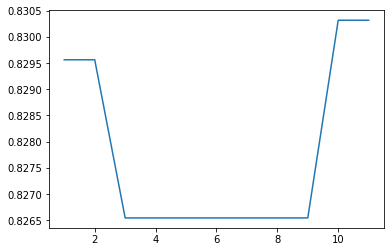

In [464]:
plt.plot(min_splits, min_splits_scores)

In [465]:
np.unique(prediction)

array([0])

На последних итерациях классификаторы стали вырожденными, поэтому за оптимальное min_splits возьмем 1

In [466]:
best_min_samples_split = 2

In [472]:
max_depths = [1, 2, 5, 10, 20, 50, 100, 200]
max_depths_scores = []
for d in max_depths:
    dates_clf = MyDecisionTreeClassifier(max_depth=d, min_samples_split=1)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc = accuracy_score(prediction, y_test)
    max_depths_scores.append(acc)
    print(f"max_depth: {d} accuracy: {acc}")

max_depth: 1 accuracy: 0.830316742081448
max_depth: 2 accuracy: 0.830316742081448
max_depth: 5 accuracy: 0.8295625942684767
max_depth: 10 accuracy: 0.8288084464555053
max_depth: 20 accuracy: 0.8288084464555053
max_depth: 50 accuracy: 0.8288084464555053
max_depth: 100 accuracy: 0.8288084464555053
max_depth: 200 accuracy: 0.8288084464555053


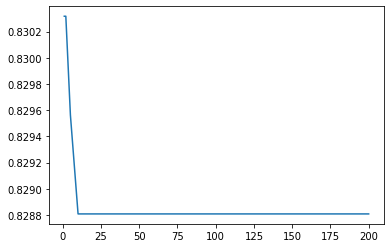

In [474]:
plt.plot(max_depths, max_depths_scores)

На первых итерациях классификаторы стали вырожденными, поэтому за оптимальное max_depth возьмем 10

In [475]:
best_max_depth = 10

In [476]:
criterions = ["gini", "class_error", "entropy"]
criterion_scores = []
for c in criterions:
    dates_clf = MyDecisionTreeClassifier(criterion=c, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc = accuracy_score(prediction, y_test)
    criterion_scores.append(acc)
    print(f"criterion: {c} accuracy: {acc}")

criterion: gini accuracy: 0.8295625942684767
criterion: class_error accuracy: 0.8318250377073907
criterion: entropy accuracy: 0.8295625942684767


Лучшим критерием оказался class_error

In [537]:
best_clf = MyDecisionTreeClassifier(min_samples_split=best_min_samples_split, max_depth=best_max_depth, criterion="class_error")
best_clf.fit(X_train, y_train)
best_prediction = best_clf.predict(X_test)
best_acc = accuracy_score(best_prediction, y_test)
best_acc

0.8318250377073907

In [504]:
best_clf.tree

{0: (0, 31, 10.0),
 1: (0, 0, 164.0),
 3: (0, 32, 8.0),
 7: (0, 0, 69.0),
 15: (0, 0, 52.0),
 31: (1, 0, 0.8835616438356164),
 32: (1, 0, 0.9607843137254902),
 16: (0, 18, 80.0),
 33: (0, 24, 1.0),
 67: (1, 0, 1.0),
 68: (0, 40, 0.19425287356321838),
 137: (0, 0, 94.0),
 275: (1, 0, 0.75),
 276: (0, 12, 50.0),
 553: (0, 39, 0.20639147802929428),
 1107: (1, 0, 0.8115942028985508),
 1108: (1, 0, 0.5),
 554: (0, 27, 7.5),
 1109: (1, 0, 1.0),
 1110: (1, 1, 1.0),
 138: (0, 23, 15.0),
 277: (0, 32, 6.0),
 555: (1, 1, 1.0),
 556: (0, 1, 28.0),
 1113: (1, 0, 0.9333333333333333),
 1114: (1, 0, 0.5),
 278: (1, 1, 0.5454545454545454),
 34: (1, 0, 0.6),
 8: (0, 24, 1.0),
 17: (0, 0, 53.0),
 35: (1, 0, 1.0),
 36: (1, 0, 1.0),
 18: (0, 76, 0.14155448717948718),
 37: (1, 0, 1.0),
 38: (0, 70, 8.0),
 77: (0, 0, 107.0),
 155: (1, 1, 0.8),
 156: (1, 1, 1.0),
 78: (0, 4, 0.17),
 157: (1, 0, 0.75),
 158: (1, 1, 0.8333333333333334),
 4: (1, 0, 0.8484848484848485),
 2: (0, 26, 9.5),
 5: (1, 1, 0.77777777777

In [505]:
np.unique(best_prediction, return_counts=True)

(array([0, 1]), array([1294,   32]))

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

<BarContainer object of 82 artists>

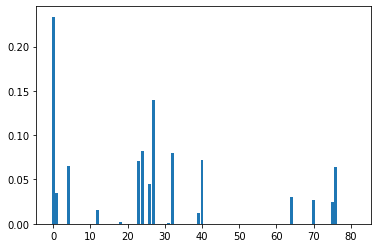

In [542]:
imps = best_clf.get_feature_importance()
plt.bar(range(imps.shape[0]), imps)

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

